In [1]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

As we seek to deploy machine learning systems not only on virtual domains, but also in real systems, it becomes critical that we examine not only whether the systems don't simply work "most of the time", but which are truly robust and reliable.  Although many notions of robustness and reliability exist, one particular topic in this area that has raised a great deal of interest in recent years is that of adversarial robustness: can we develop classifiers that are robust to (test time) perturbations of their inputs, by an adversary intent on fooling the classifier?  This is of course a very specific notion of robustness in general, but one that seems to bring to the forefront many of the deficiencies facing modern machine learning systems, especially those based upon deep learning.

This tutorial seeks to provide a broad, hands-on introduction to this topic of adversarial robustness in deep learning.  The goal is combine both a mathematical presentation and illustrative code examples that highlight some of the key methods and challenges in this setting.  With this goal in mind, the tutorial is provided as a static web site, but all the sections are also downloadable as Jupyter Notebooks; this lets you try out and build upon the ideas presented here.

Although we try to touch on most of the high-level ideas that have been driving research in this area of work, it is certain that we will also omit some highly relevant work.  If you feel that some work deserves to be mentioned in the context that we are discussing, feel free to get in touch and let us know.  Our hope is that this resource can serve as a starting point for people just getting involved in the area, as well as a launching pad of links and resources for those who want to pursue the ideas more deeply.


### Logistics
Although this tutorial is intended to be mainly read as a static page, because, as mentioned above, you can also download the notebooks for each section, we briefly mention the requirements for running the full examples seen here.  Specifically, all example here use Python 3.7 (though should be compatible with 3.6), and make use of the following libraries:
  - [pytorch 1.0](https://pytorch.org)
  - [cvxpy 1.0](http://cvxpy.org)
  - numpy/scipy/PIL/etc

Ideally, the precise version number should not matter, and the approach should be compatible with e.g. pytorch 0.4.x (but not earlier), earlier versions of pillow, etc.  We installed all this software by with a fresh install of [Anaconda](https://www.anaconda.com/) (which includes all of the needed libraries except PyTorch and cvxpy), then used the `conda install <package>` or `pip install <package>` commands to install all the relevant software.  We also provide a docker container capable of running all the notebooks in our github repository.  You will only need cvxpy for some of the optimization-related approaches we discuss, and most of the tutorial can be done without this tool, but PyTorch is used quite heavily throughout.

Many of the simpler examples are quite fast to compute, and so we just implement them on a CPU.  For the more time-intensive operations, however (especially the various types of adverarial training), it is necessarly to train the systems on a GPU to have any hope of being computationally efficient.  Thus, in order to run these later examples, you will also need CUDA installed with the above version of PyTorch.

### Required background

This document assumes some degree of familiarity with basic deep learning, e.g., the basics of optimization, gradient descent, deep networks, etc (to the degree that is typically covered in an early graduate-level course on machine learning), plus some basic familiarity with PyTorch.  If you do not have either of these, then a good resource to start will be:

  - Deep Learning book, etc
  - Resources to fill in later

## Diving right in

One of the beautiful things about deep learning is just how easy it is to jump right in and start seeing some actual results on real data.  With that mindset, let's start off by constructing our very first adversarial example.  We will introduce a very small amount of mathematical notation here, which will be substantially expanded upon shortly, and the actual technique we use here is not the ultimate strategy that we will use, but it is fairly close in spirit, and actually captures most of the basic components that we will see later.

To start off, let's use the (pre-trained) ResNet50 model within PyTorch to classify this picture of a pig.
!['Show Pig' licensed under CC BY 2.0](pig.jpg)
The normal strategy for image classification in PyTorch is to first transform the image (to approximately zero-mean, unit variance) using the `torchvision.transforms` module.  However, because we'd like to make perturbations in the original (unnormalized) image space, we'll take a slightly different approach and actually build the transformations at PyTorch layers, so that we can directly feed the image in.  First, let's just load the image and resize the **224x224**, which is the default size that most ImageNet images (and hence the pre-trained classifiers) take as input.


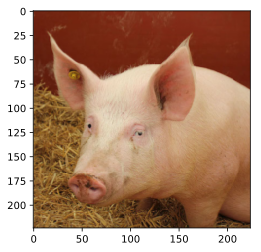

In [2]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch uses CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

Now let's load the pre-trained ResNet50 model and apply it to the image, after necessary transforms (the weird indexing here is just used to comply with PyTorch standards that all inputs to modules should be of the form `batch_size x num_channels x height x width`).

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [5]:
# form predictions
pred = model(norm(pig_tensor))

`pred` now contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes (i.e., if you wanted to convert this to a probability vector, you would apply the softmax operator to this vector).  To find the highest likelihood class, we simply take the index of maximum value in this vector, and we can look this up in a list of imagenet classes to find the corresponding label.

In [6]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


Loooking good! (note that ImageNet has one class correpsonding to both "hog" and "pig", so this is the correct label).  We should note that this is the first pig image we tried here, so it doesn't take any tweaking to get a result like this ... modern image classifiers are pretty impressive.

### Some introductory notation
Now let's try to fool this classifier into thinking this image of a pig is something else.  To explain this process, we're going to introduce a bit more notation.  Specifically, we'll define the define the model, or hypothesis function, $h_\theta : \mathcal{X} \rightarrow \mathbb{R}^k$ as the mapping from input space (in the above example this would be a three dimensional tensor), to the output space, which is a $k$-dimensional vector, where $k$ is the number of classes being predicted; note that like in our model above, the output corresponds to the logit space, so these are real-valued numbers that can be positive or negative.  The $\theta$ vector represents all the parameters defining this model, (i.e., all the convolutional filters, fully-connected layer weight matrices, baises, etc; the $\theta$ parameters are what we typically optimize over when we train a neural network.  And finally, note that this $h_\theta$ corresponds precisely the `model` object in the Python code above.

Second, we define a loss function $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$ as a mapping from the model predictions and true labels to a non-negative number.  The semantics of this loss function are that the first argument is the model output (logits which can be positive or negative), and the second argument is the _index_ of the true class (that is, a number from 1 to $k$ denoting the index of the true label). Thus, the notation
\begin{equation}
\ell(h_\theta(x), y)
\end{equation}
for $x \in \mathcal{X}$ the input and $y \in \mathbb{Z}$ the true class, denotes the loss that the classifier achieves in its predictions on $x$, assuming the true class is $y$.  **By far the most common form of loss used in deep learning is the cross entropy loss (also sometimes called the softmax loss)**, defined as
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y
\end{equation}
where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

**Aside:** For those who are unfamiliar with the convention above, note that the form of this loss function comes from the typical softmax activation.  Defining the softmax operator $\sigma : \mathbb{R}^k \rightarrow \mathbb{R}^k$ applied to a vector
\begin{equation}
\sigma(z)_i = \frac{exp(z_i)}{\sum_{j=1}^{k}\exp(z_{j})}
\end{equation}
to be a mapping from the class logits returned by $h_\theta$ to a probability distribution.  Then the typical goal of training a network is to maximize the probability of the true class label.  Since probabilities themselves get vanishingly small, it is more common to maximize the _log_ of the probability of the true class label, which is given by
\begin{equation}
\log \sigma(h_\theta(x))_y = \log \left(\frac{exp(h_\theta(x)_y)}{\sum_{j=1}^{k}\exp(h_\theta(x)_{j})} \right) = h_\theta(x)_y - \log \left (\sum_{j=1}^{k}\exp(h_\theta(x)_{j}) \right ).
\end{equation}
Since the convention is that we want to _minimize_ loss (rather than maximizing probability), we use the negation of this quantity as our loss function.  We can evaluate this loss in PyTorch using the following command.

In [7]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.0038814544677734375


A loss of 0.0039 is pretty small: by the conventions above, that would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig.

### Creating an adversarial example
So how do we manipulate this image to make the classifier believe it is something else?  To answer this, note that by common approach to training a classifier is to optimize the _parameters_ $\theta$, so as to minimize the average loss over some training set $\{x_i \in \mathcal{X}, y_i \in \mathbb{Z}\}$, $i=1,\ldots,m$, which we write as the optimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
\end{equation}
which we typically solve by (stochastic) gradient descent.  I.e., for some minibatch $\mathcal{B} \subseteq \{1,\ldots,m\}$, we compute the gradient of our loss with respect to the parameters $\theta$, and make a small adjustment to $\theta$ in this negative direction
\begin{equation}
\theta := \theta - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_\theta \ell(h_\theta(x_i), y_i)
\end{equation}
where $\alpha$ is some step size, and we repeat this process for different minibatches covering the entire training set, until the parameters convergenc.

The key term of interest here is the gradient $\nabla_\theta \ell(h_\theta(x_i), y_i)$, which computes how a small adjustment to each the parameters $\theta$ will affect the loss function.  For deep neural networks, this gradient is computed efficiently via backpropagation.  However, the beauty of automatic differentiation (the mathematical technique that underlies backpropagation), is that we aren't just limited to differentiating the loss with respect to $\theta$; we can just as easily compute the gradient of the loss with respect to the input $x_i$ itself.  This quantity will tell us how small changes to the image itself affect the loss function.

This is exactly what we're going to do to form an adversarial example.  But instead of adjusting the image to minimize the loss, as we did when optimizing over the network parameters, we're going to adjust the image to _maximize_ the loss.  That is, we want to solve the optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\hat{x}} \ell(h_\theta(\hat{x}), y)
\end{equation}
where $\hat{x}$ denotes our adversarial example that is attempting to maximize the loss.  Of course, we cannot just optimize arbitrarily over $\hat{x}$ (there do exist, after all, some images that are _not_ pigs, and if we change the image entirely, say to a dog, then it's not particularly impressive that we can "fool" the classifier into thinking it's not a pig).  So we instead need to ensure that $\hat{x}$ is close to our original input $x$.  By convention, we typically do this by optimizing over the _perturbation_ to $x$, which we will denote $\delta$, and then by optimizing over $\delta$
\begin{equation}
\maximize_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}
where $\Delta$ represents an allowable set of perturbations.  Characterizing the "correct" set of allowable perturbations is actually quite difficult: in theory, we would like $\Delta$ to capture anything that humans visually feel to be the "same" as the original input $x$.  This can include anthing ranging from adding slight amounts of noise, to rotating, translating, scaling, or performing some 3D transformation on the underlying model, or even completely changing the image in the "non-pig" locations.  Needless to say, it is not possible to give a mathematically rigorous definition of all the perturbations that _should_ be allowed, but the philosophy behind adversarial examples is that we can consider some _subset_ of the possible space of allowed perturbations, such that by any "reasonable" definition, the actual semantic content of the image could not change under this perturbation.

A common perturbation set to use, though by no means the only reasonable choice, is the $\ell_\infty$ ball, defined by the set
\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}
where the $\ell_\infty$ norm a vector $z$ is defined as
\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}
i.e., we allow the perturbation to have magnitude between $[-\epsilon, \epsilon]$ in each of its components (it is a slightly more complex, as we also need to ensure that $x + \delta$ is also bounded between $[0,1]$ so that it is still a valid image).  We'll return later to debeate whether or not is it reasonable to consider the $\ell_\infty$ ball, or norm-balls in general as perturbation sets.  But all we will say for now is that the advantage of the $\ell_\infty$ ball is that for small $\epsilon$ it creates perturbations which add _such_ a small component to each pixel in the image that they are visually indistinguishable from the original image, and thus provide a "necessarily-but-definitely-not-close-to-sufficient" condition for us to consider a classifier robust to perturbations.  And the reality of deep networks is that they can very easily be fooled by manipulations precisely of this type.

Ok, enough discussion.  Let's see what this looks like in practice.  The following example uses PyTorch's `SGD` optimizer to adjust our perturbation to the input to maximize the loss.  Derspite the name, since there is no notion of a training set or minibatches here, this is not actually stochastic gradient descent, but just gradient descent; and since we follow each step with a projection back onto the $\ell_\infty$ ball (done by simply clipping the values that exceed $\epsilon$ magnitude to $\pm \epsilon$), this is actually a procedure known as projected gradient descent (PGD).  We'll shortly consider slightly more complex versions (where we'll need to things explicitly instead of using PyTorch's optimization class), but we'll keep things simple for now.

In [8]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.0038814544677734375
5 -0.0069332122802734375
10 -0.015834808349609375
15 -0.08054828643798828
20 -11.83158016204834
25 -15.96520709991455
True class probability: 1.3332296475709882e-06


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-5}$ chance of being a pig.  (Note: we should also clip $x + \delta$ to be in $[0,1]$, but this already holds for any $\delta$ within the above bound, so we don't need to do it explicitly here).  Instead, it turns out that this classifier is quite sure the image is a wombat, as we can see from the following code, which computes the maximum class and its probability.

In [9]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9994586110115051


So what does this wombat-pig look like?  Extremely similar to our original pig, unfortunately.

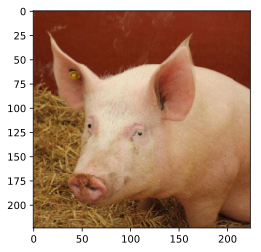

In [10]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

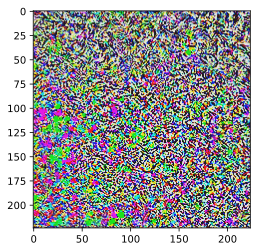

In [11]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

So essentially, by adding a tiny multiple of this random-looking noise, we're able to create an image that looks identical to our original image, yet is classified very incorrectly.  Of course, to do all of this more correctly, we should quantize our noise to the allowable level of the image (i.e., to within steps of 1/255), but technicalities like this are easy to overcome, and we can indeed create valid images which are impossible for the human eye to distinguish between them and our original image, but which the classifier misclassifies.

### Targeted attacks
Ok, you might say.  This is impressive, but a wombat really isn't _that_ different from a pig, so maybe the problem isn't that bad.  But it turns out this same technique can be used to make the image classified as virtually any class we desire.  This is known as a "targeted attack", and the only difference is that instead of trying to just maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class.  That is, we solve the optimization problem
\begin{equation}
\maximize_{\delta \in \Delta} \left (\ell(h_\theta(x +\delta), y) - \ell(h_\theta(x +\delta), y_{\mathrm{target}}) \right) \equiv \maximize_{\delta \in \Delta} \left(h_\theta(x+\delta)_{y_{\mathrm{target}}} - h_\theta(x+\delta)_{y} ]\right )
\end{equation}
where the expression simplies because the $\log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right )$ terms from each loss cancel, and all that remains is the linear terms.  Here is how this looks.  Note that we tuned the step size a bit to make it work in this case, but we'll shortly consider slightly different scaling methods for projected gradient descent where this isn't needed.

In [12]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.006053924560547
10 0.16659879684448242
20 -8.138786315917969
30 -15.182465553283691
40 -20.25279426574707
50 -26.148908615112305
60 -30.571914672851562
70 -35.386199951171875
80 -37.99042510986328
90 -43.520835876464844


In [14]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.966678261756897


As before, here's our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working)

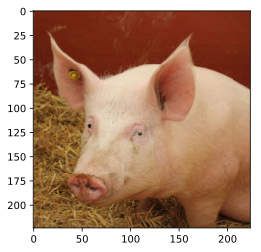

In [15]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

And here is our airliner noise.

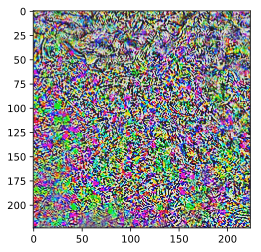

In [16]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

The conclusion, of course, is that with adversarial attacks and deep learning, you can make pigs fly.  [Important note: this tutorial is written jointly by Zico and Aleksander, but this pun is Aleksander's.  Zico disavows any association with this one part of the tutorial.]

We'll discuss the practical questions that these attacks raise shortly, but the ease of such attacks raises an obvious question: can we train deep learning classifiers that are somehow resistant to such attacks?  The short answer to this question is "yes", but we (as a field) are a long way from really making such training practical, or achieving nearly the performance that we get with "standard" deep learning methods.  This tutorial will cover both the attack and the defense side in great detail, and hopefully by the end of it, you will get a sense of the current state of the art, as well as the directions where we still need to make substantial progress.

## A brief (incomplete) history of adversarial robustness

  - Origins (robust optimization)
  - Support vector machines
  - Adversarial classification (e.g. Domingos 2004)
  - Distinctions between different types of robustness (test test, train time, etc)
  - Szgegy et al., 2003, Goodfellow et al., 2004
  - Many proposed defense methods
  - Many proposed attack methods
  - Exact verification methods
  - Convex upper bound methods
  - Recent trends

## Adversarial robustness and training

Let's now consider, a bit more formally, the challenge of attacking deep learning classifiers (here meaning, constructing adversarial examples them the classifier), _and_ the challenge of training or somehow modifying existing classifiers in a manner that makes them more resistant to such attacks.


### Brief review: risk, training, and testing sets
To begin, we can consider more formally the traditional notion of _risk_ as it is used in machine learning.  The risk of a classifier is it's expected loss under the true distribution of samples, i.e.
\begin{equation}
R(h_\theta) = \mathbf{E}_{(x,y)\sim\mathcal{D}}[\ell(h_\theta(x)),y)]
\end{equation}
where $\mathcal{D}$ denotes the true distribution over samples.  In practice, of course, we do not know the underlying distribution of the actual data, so we approximate this quantity by considering a finite set of samples drawn draw i.i.d. from $\mathcal{D}$,
\begin{equation}
D = \{(x_i,y_i) \sim \mathcal{D}\}, i=1,\ldots,m
\end{equation}
and we then consider the empirical risk
\begin{equation}
\hat{R}(h_\theta,D) = \frac{1}{|D|}\sum_{(x,y) \in D} \ell(h_\theta(x)),y).
\end{equation}

As mentioned above, the traditional process of training a machine learning algorithm is that of finding parameters that minimize the empirical risk on some training set denoted $D_{\mathrm{train}}$ (or possibly some regularized version of this objective)
\begin{equation}
\minimize_\theta \hat{R}(h_\theta, D_{\mathrm{train}}).
\end{equation}

Of course, once the parameters $\theta$ have been chosen based upon the training set $D_{\mathrm{train}}$, this data set can no longer give us an unbiased estimated of the risk of the resulting classifier, and so frequently an alterntaive data set $D_{\mathrm{test}}$ (also contains points sampled i.i.d. from the true underlying distribution $\mathcal{D}$), and we use $\hat{R}(h_\theta, D_{\mathrm{test}})$ as a proxy to estimate the true risk $R(h_{\theta})$.


### Adversarial risk
As an alternative to the traditional risk, we can also consider an _adversarial risk_.  This is like the traditional risk, except that instead of suffering the loss on each sample point $\ell(h_\theta(x), y)$, we suffer the _worst case_ loss in some region around the sample point, that is
\begin{equation}
R_{\mathrm{adv}}(h_\theta) = \mathbf{E}_{(x,y)\sim\mathcal{D}}\left[\max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) \right ]
\end{equation}
where for completeness, we explicitly allow that the perturbation region $\Delta(x)$ can depend on the sample point itself; using the examples from the previous sections, this would be necessary in order to ensure that perturbations respected the ultimate image bounds, but it can also potentially encode a great deal of semantic information about what sorts of perturbations would be allowed for each image.

There are also, naturally, the empirical analog of the adversarial risk, which looks exactly like what we considered in the previous sections
\begin{equation}
\hat{R}_{\mathrm{adv}}(h_\theta, D) = \frac{1}{|D|}\sum_{(x,y)\in D} \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) .
\end{equation}
This quantity essentially measures the worst-case empirical loss of the classifier, if we are able to adversarially manipulate every input in the data set within its allowable set $\Delta(x).

Why might we prefer to use the adversarial risk instead of the traditional risk?  If we are truly operating in an adversarial environment, where an adversary is capable of manipulating the input with full knowledge of the classifier, then this would provide a more accurate estimate of the expected performance of a classifier.  This may seem unlikely in practice, but several classification tasks (especially those relating to computer security) such as spam classification, malware detection, network intrusion detection, etc, are genuinely adversarial, where attackers have an direct incentive to fool a classifier.  Or even if we don't expect the evironment to _always_ be adversarial, some applications of machine learning seem to be high-stakes enough that we would like to understand the "worst case" performance of the classifier, even if this is an unlikely event; this sort of logic underlies the interest in adversarial examples in domains like autonomous driving, where for instance there has been work looking at ways that stop signs could be manipulated to intentionally fool a classifier [\cite].

However, there is also a reasonable case to be made that we might prefer _empirical adversarial risk_ over traditional empirical risk, _even if we ultimately want to minimize the traditional risk_.  The reason for this is that it is very difficult to actually draw samples i.i.d. from the true underlying distribution.  Instead, any procedure we use to collect data is an empirical attempt at accessing the true underlying distribution, and may ignore certain dimensions, especially if these appear "obvious" to humans.  This is hopefully somewhat obvious even on the previous image classification example.  There has been a lot of recent claims that [algorithms have "surpassed human performance" on image classification](https://www.eetimes.com/document.asp?doc_id=1325712), using classifiers like the one we saw as an example.  But, as the above example illustrates, algorithms are nowhere _near_ human performance, if they cannot even recognize that an image that looks _exactly the same_, by any visual definition, as the original image, in fact belongs to the same class.  Some may argue that these cases "shouldn't count" because they were specifically designed to fool the algorithm in question, and may not correspond to an image that will ever be viewed in pratice, but much simpler pertrubations such as translations and rotations _also_ can serve as adversarial examples [\cite, \cite].

The fundamental problem is that when claims are made of "human level" performance by ML systems, they really mean "human level on data generated _exactly_ by the sampling mechanism used in this experiment."  But humans don't do well just on one sampling distribution; humans are _amazingly_ resilient to changes in the environment.  So when people are told that machine learning algorithms "surpass human performance" (especially when conjoined, as they often are, by claims that the associated deep learning algorithms "work like the human brain"), it often leads to the implicit assumption that the algorithms will _also_ be similarly resilient.  But they are not; deep learning algorithms are _incredibly_ brittle, and adversarial examples lay this fact bare, in a very obvious and intuitive manner.  Put another way, can't we at least agree to cool it on the "human level", and "works like the human brain" talk for systems that are as confidence that the first image is a pig as as they are that the second image is an airplane?

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

### Training adversarially robust classifiers

With this motivation in mind, let's now consider the task of training a classifier that is robust to adversarial attacks (or equivalently, one that minimizes the empirical adversarial risk).  Analogous to the case of traditional training, this can be written as the optimization problem
\begin{equation}
\minimize_\theta \hat{R}_{\mathrm{adv}}(h_\theta, D_{\mathrm{train}}) 
\equiv \minimize_\theta \frac{1}{|D_{\mathrm{train}}|}\sum_{(x,y)\in D_{\mathrm{train}}} \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) .
\end{equation}
**We will refer to this as the _min-max_ or _robust optimization_ formulation of adversarial learning, and we will return to it many times during the course of this tutorial.**

As with traditional training, the way we would solve this optimization problem in practice is by stochastic gradient descent over $\theta$.  That is, we would repeatedly choose a minibatch $B \subseteq D_{\mathrm{train}}$, and update $\theta$ according to its gradient
\begin{equation}
\theta := \theta - \frac{\alpha}{|B|} \sum_{(x,y)\in B} \nabla_\theta \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y).
\end{equation}
But how do we compute the gradient of the inner term now, given that the inner function itself contains a maximization problem?  The answer is fortunately quite simple in practice, and given by [Danskin's theorem](https://en.wikipedia.org/wiki/Danskin%27s_theorem).  For the purposes of our discussion, it states that the gradient of the inner function involving the maximization term is simply given by the gradient of the function evaluated at this maximum.  In other words, letting $\delta^\star$ denote the optimum of the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\delta^\star = \argmax_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y)
\end{equation}
the gradient we require is simply given by 
\begin{equation}
\nabla_\theta \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) = \nabla_\theta \ell(h_\theta(x + \delta^\star)),y)
\end{equation}
(where in the right hand side, we treat $\delta^\star$ just as a fixed quantity, i.e., we don't worry about its dependence on $\theta$).  This may seem to be "obvious", but it is actually quite a subtle point, and it is not trivial to show that this holds (after all the obtained value of $\delta^\star$ depends on $\theta$, so it is not clear why we can treat it as independent of $\theta$ when taking gradient).  We don't prove Danskin's theorem here, and will simply note that this property of course makes our lives much easier.

Given this framework, there is a nice interplay between the challenge of finding an adversarial example, and the process of training a robust classifier.  Specifically, the process of gradient descent on the empircal adversarial risk would look something like the following
  1. For each $x,y \in B$, solve the inner maximization problem (i.e., compute an adversarial example)
  \begin{equation}
  \delta^\star(s) = \argmax_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y)
  \end{equation}
  2. Compute the gradient of the empirical adversarial risk, and update $\theta$
  \begin{equation}
  \theta := \theta - \frac{\alpha}{|B|} \sum_{(x,y)\in B} \nabla_\theta \ell(h_\theta(x + \delta^\star(x))),y).
  \end{equation}

In other words, we iteratively compute adversarial examples, and then update the classifier based not upon the original data points, but upon these adversarial examples.  This procedure has become known as "adversarial training" in the deep learning literature, and (if done properly, more on this shortly) it is one of the most effective empirical methods we have for training adverarially robust models, though a few caveats are worth mentioning.

First, we should note that we are virtually never _actually_ performing gradient descent on the true empirical adversarial risk, precisely because we typically cannot solve the inner maximization problem optimally.  Specifically, the inner maximization, if done via gradient descent like we did above, is a non-convex optimization problem, where we are only able at best to find a local optimum, when using techniques such as gradient descent.  And since Danskin's theorem, for instance, only applies in theory when the inner maximization problem is solved exactly, this would seemingly pose a problem for such approachers.  In practice, however, it typically is the case that if the inner optimization problem is solved "well enough", then the strategy performs well.  It is, though, quite dependent on just how well this inner optimization problem is indeed solved; if only a poor approximate strategy is used to solve the inner maximization problem then there is a good chance that a slightly more exhaustive inner optimization strategy will prove an effective attack.  This is why the best current strategies are ones that explicitly solve this inner optimization problem (even approximately) as well as possible, making it as difficult as possible (thoug not impossible) for a subsequent strategy to simply "out optimize" the trained robustness.

Second, although in theory one can take just the worst-case perturbation as the point at which to compute the gradient, in practice this can cause osscilations of the training process, and it is often better to incorporate multiple perturbations with different random initializations and potentially also a gradient based upon the initial point with no perturbation.

Finally, we should note that some robust training methods (specifically, those based upon uppon bounds on the inner maximization problem), actually do _not_ require iteratively finding an adversarial point and then optimizating; instead, these produce a closed form bound on the inner maximization, that can be solved non-iteratively.  We will discuss such approaches a great deal more in the subsequent sections.

### Final comments

Before moving on, we want to make one additional comment about the value of the robust optimization formulation of adversarial robustness.  It is important to emphasize that **every adversarial attack and defense are a method for approximately solving the inner maximization and/or outer minimization problem respectively**.  Even papers that do not express themselves this way, _are_ attempting to solve these problems (albeit wwith some potential differences, e.g. considering directly a different loss such as the 0/1 loss intead of the cross entropy loss).

In our opinion (and this particular paragraph should very much be interpreted now as the opinion of Zico and Aleksander), one notable challenge with the field is that many papers present an attack or defense in terms of the _method_ it uses, rather than the _problem_ (meaning, optimization problem) it solves.  This is how we get many different names for many different strategies that all consider some minor variant of the above optimization, such as considering different norm bounds in the $\Delta(x)$ term, using different optimization procedures to solve the inner maximization problem, or using seemingly very extravagent techniques to defends against attacks, which often don't seem to clearly relate to the optimization formulation at all.  While it's certainly possible that one such method could prove more effective than the best known strategies we have, the history the more heuristic attack and defense strategies has not been good [\cite].

With all of this in mind, the agenda for the next chapters of this tutorial should hopefully be clear.  In Chapter 2, we will first take a bit of a digression to show how all these issues work in the case of _linear_ models; perhaps not surprisingly, in the linear case, the inner maximization problem we discussed _can_ be solved exactly (or very closely upper bound), and we can make very strong statements about the performance of these models in adversarial settings.  Next, in Chapter 3, we will return to the world of deep networks, and look at the inner maximization problem, focusing on the three general classes of approaches that can be applied: 1) lower bounds (i.e., constructing the adversarial example), 2) exact solutions (via combinatorial optimization), 3) upper bounds (usually with some more-tractable strategy).  In Chapter 4, we then address the problem of training adversarial models, which typically involve either adversarial training using the lower bound, or "certified" robust training involving the upper bounds (adversarial training using the exact combinatorial solutions has not yet been proved feasible).  Finally, Chapter 5 returns to some of the bigger picture questions from this Chapter, and more: here we discuss the value of adversarial robustness beyond the typical "security" justifications; instead, we consider advesarial robustness in the context of regularization, generalization, and the meaningfulness of the learned representations.
